In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# accuracy_score not called
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns  
from collections import Counter
import json

In [3]:
Ks = range(1,11)
trn_acc = []
val_acc = []
bestk = 0
testAcc = 0.0

def remove_duplicates(dataset: pd.DataFrame):
    return dataset.drop_duplicates()

def remove_missing_targets(dataset: pd.DataFrame, target):
    return dataset.dropna(subset=[target])

def impute_missing_values(features: pd.DataFrame):
    for column in features.columns:
        features.fillna(features[column].mean(), inplace=True)
    return features

def feature_transformation(x_train: pd.DataFrame, x_validation: pd.DataFrame, x_test: pd.DataFrame):
    # Robust transform (value - median) / IQR
    median = np.median(x_train)
    q1 = np.quantile(x_train, .25, axis= 0)
    q3 = np.quantile(x_train, .75, axis= 0)
    iqr = q3 - q1
    
    # Avoid division by zero
    iqr[iqr == 0] = 1e-8

    x_train_scaled = (x_train - median) / iqr
    x_validation_scaled = (x_validation - median) / iqr
    x_test_scaled = (x_test - median) / iqr

    return x_train_scaled, x_validation_scaled, x_test_scaled

def data_split(X: pd.DataFrame, y: pd.DataFrame | pd.Series, test_size, random_state):

    X_test = X.sample(frac=test_size, random_state=random_state)
    X_train = X.drop(X_test.index)

    y_train = y[X_train.index]
    y_test = y[X_test.index]

    return X_train, X_test, y_train, y_test

def data_preprocessing(dataset: pd.DataFrame):

    dataset.drop('Unnamed: 0', axis=1, inplace=True)
    dataset = remove_duplicates(dataset)

    target = 'class'
    dataset = remove_missing_targets(dataset, target)

    X = dataset.drop(target, axis=1)
    y = dataset[target]

    X = impute_missing_values(X)

    x_train, x_temp, y_train, y_temp = data_split(X, y, test_size=0.3, random_state=42)
    x_test, x_validation, y_test, y_validation = data_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    x_train, x_validation, x_test = feature_transformation(x_train, x_validation, x_test)

    return x_train, y_train, x_validation, y_validation, x_test, y_test


class knn_classifier():
    def __init__(self, n_neighbor):
        self.n_neighbour = n_neighbor

    def model_learn(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X.to_numpy():
            predictions.append(self._predict_single(x))
        return np.array(predictions)
    
    def euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))
    
    def _predict_single(self, x):
        distances = self.euclidean_distance(self.X_train, x)
        k_indices = np.argsort(distances)[:self.n_neighbour]
        k_nearest_labels = self.y_train.iloc[k_indices]
        ##
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    
    def accuracy(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        return correct / len(y_true)      

    def knn_classifier(self, dataset):
        global Ks, trn_acc, val_acc, bestk, testAcc

        X_train, y_train, X_validation, y_validation, X_test, y_test = data_preprocessing(dataset)
        
        k_values = range(1,11)
        training_accuracy = []
        validation_accuracy = []

        for k in k_values:
            print(f"Testing k={k}...") 
            self.n_neighbour = k
            self.model_learn(X_train, y_train)

            val_pred = self.predict(X_validation)
            train_pred = self.predict(X_train)
            
            training_accuracy.append(self.accuracy(y_train, train_pred))
            validation_accuracy.append(self.accuracy(y_validation, val_pred))

        training_accuracy = np.array(training_accuracy)
        validation_accuracy = np.array(validation_accuracy)

        best_k_val = np.argmax(validation_accuracy) + 1
        best_acc_val = validation_accuracy[best_k_val - 1]

        best_k_train = np.argmax(training_accuracy) + 1
        best_acc_train = training_accuracy[best_k_train - 1]

        print(f"Best validation accuracy: {best_acc_val:.4f} at k={best_k_val}")
        print(f"Best training accuracy: {best_acc_train:.4f} at k={best_k_train}")

        plt.figure(figsize=(8, 5))
        plt.plot(k_values, training_accuracy, label="Training Accuracy", marker='o')
        plt.plot(k_values, validation_accuracy, label="Validation Accuracy", marker='o')
        plt.scatter(best_k_val, best_acc_val, color='red', s=100, label=f"Best k={best_k_val}")
        plt.xlabel("Number of Neighbors (k)")
        plt.ylabel("Accuracy")
        plt.title("KNN Accuracy vs Number of Neighbors")
        plt.legend()
        plt.grid(True)
        plt.show()

        self.n_neighbour = best_k_val
        self.model_learn(X_train, y_train)

        test_pred = self.predict(X_test)
        test_accuracy = self.accuracy(y_test, test_pred)

        print(f"Test accuracy: {test_accuracy:.4f} at k={best_k_val}")

        # Compute classification metrics
        precision = precision_score(y_test, test_pred, average='weighted')
        recall = recall_score(y_test, test_pred, average='weighted')
        f1 = f1_score(y_test, test_pred, average='weighted')
        cm = confusion_matrix(y_test, test_pred)

        print("\nClassification Report:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        plt.figure(figsize=(7, 5))
        plt.scatter(best_k_val, test_accuracy, color='red', s=100, label=f"Test Accuracy={test_accuracy:.2f}")
        plt.xlabel("Best k")
        plt.ylabel("Accuracy")
        plt.title("Test KNN Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

        trn_acc = training_accuracy
        val_acc = validation_accuracy
        bestk = best_k_val
        testAcc = test_accuracy

Testing k=1...
Testing k=2...
Testing k=3...
Testing k=4...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...
Best validation accuracy: 0.8367 at k=8
Best training accuracy: 1.0000 at k=1


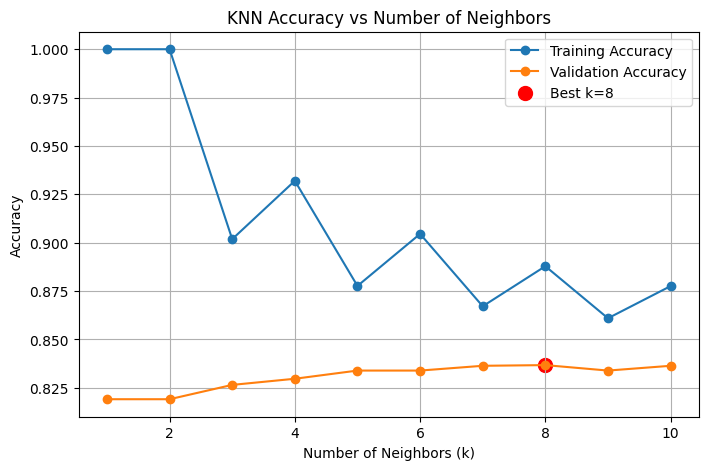

Test accuracy: 0.8343 at k=8

Classification Report:
Precision: 0.8381
Recall: 0.8343
F1 Score: 0.8260


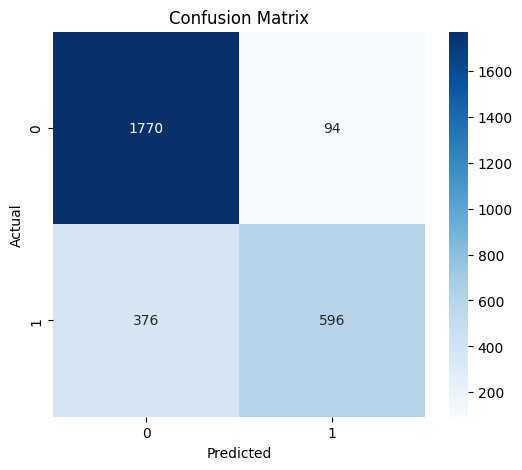

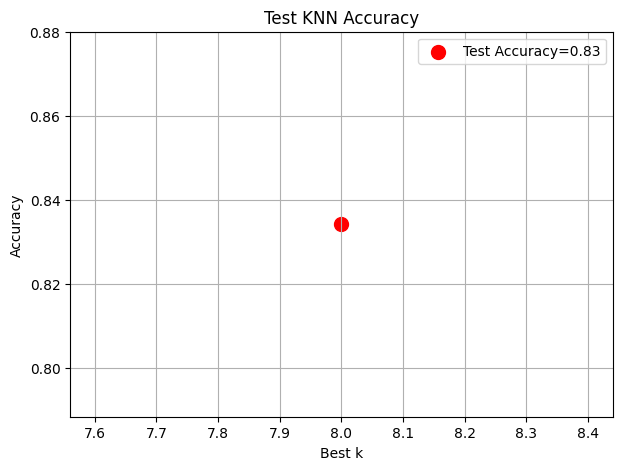

In [4]:
df = pd.read_csv('telescope_data.csv')
classifier = knn_classifier(n_neighbor=3)
classifier.knn_classifier(df)

In [5]:
# Save results to json
results = {
    "k_values": list(Ks),
    "training_accuracy": list(trn_acc),
    "validation_accuracy": list(val_acc),
    "best_k": int(bestk),
    "best_val_accuracy": float(testAcc)
}

with open("results_model_without_scikit.json", "w") as f:
    json.dump(results, f, indent=4)